In [ ]:
# Import Required Libraries
!pip install mido
!pip install pretty_midi
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592285 sha256=99fc47e8eb84a3768c5308340a4a212fe78e637f8e4f56717ef4bad7fa609aeb
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import shutil
import mido
import numpy as np
from keras.utils import to_categorical
import pretty_midi
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, normalize, MinMaxScaler,
    StandardScaler
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, AveragePooling2D,
    MaxPooling2D, Flatten,
    Dense, LSTM, Dropout,
    RepeatVector, Activation
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from skimage.transform import resize


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import keras_tuner

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing and Feature Extraction

In [ ]:
# Function to create a piano roll from a MIDI file
def create_piano_roll(midi_file, time_step=0.1, note_range=(21, 109)):
    '''
    Function to Return Piano Roll Representation of the MIDI File for the CNN
    '''
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    # Compute the piano roll using the given time step and note range
    time_intervals = np.arange(0, midi_data.get_end_time(), time_step)
    note_range_size = note_range[1] - note_range[0]
    piano_roll = np.zeros((len(time_intervals), note_range_size))

    for note in midi_data.instruments[0].notes:
        if note.start < time_intervals[-1]:
            note_start = np.searchsorted(time_intervals, note.start)
            note_end = np.searchsorted(time_intervals, note.end)
            if note.pitch >= note_range[0] and note.pitch < note_range[1]:
                piano_roll[note_start:note_end, note.pitch - note_range[0]] = 1

    return piano_roll

In [ ]:
def extract_features_from_midi(midi_file):
    '''
    Function to Extract the Features for LSTM Implementation
    '''
    # Open the MIDI file
    midi = mido.MidiFile(midi_file)

    # Initialize feature vectors
    features = []

  # Extract relevant features
    num_notes = 0
    total_duration = 0
    full_midi_length = 0
    time_signature = (4, 4)
    pitches = set()  # To calculate the number of distinct notes
    # scales = {"major": (0, 2, 4, 5, 7, 9, 11), "minor": (0, 2, 3, 5, 7, 8, 10)}
    # scale_notes = {scale: set() for scale in scales.keys()}

    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on':
                num_notes += 1
                pitches.add(msg.note)
                full_midi_length += msg.time
            elif msg.type == 'time_signature':
                time_signature = (msg.numerator, 2 ** msg.denominator)
            elif msg.type == 'note_off' or msg.type == 'note_on':
                total_duration += msg.time

    avg_note_frequency = num_notes / total_duration if total_duration > 0 else 0
    num_distinct_notes = len(pitches)

    features.extend([
        avg_note_frequency,
        time_signature[0],
        time_signature[1],
        full_midi_length,
        num_distinct_notes,
    ])

    return features

In [ ]:
def prepare_data(folder_path, sequence_length=100):
    X_LSTM = []
    X_CNN = []
    y = []
    for composer_label, composer_name in enumerate(os.listdir(folder_path)):
        composer_path = os.path.join(folder_path, composer_name)
        if os.path.isdir(composer_path):
            for root, _, files in os.walk(composer_path):
                for file in files:
                    if file.endswith(".mid"):
                        midi_file_path = os.path.join(root, file)
                        features = extract_features_from_midi(midi_file_path)
                        piano_roll = create_piano_roll(midi_file_path)
                        X_LSTM.append(features)
                        X_CNN.append(piano_roll)
                        y.append(composer_name)

    return np.array(X_LSTM), np.array(X_CNN), np.array(y)

In [ ]:
def preprocess_data(piano_rolls, time_steps=128, note_range=(21, 108)):
    # Reshape piano rolls to the specified time steps and note range
    reshaped_data = []
    for piano_roll in piano_rolls:
        if len(piano_roll) >= time_steps:
            reshaped_data.append(piano_roll[:time_steps, :])
        else:
            padding = np.zeros((time_steps - len(piano_roll), note_range[1] - note_range[0]))
            reshaped_data.append(np.vstack((piano_roll, padding)))

    # Normalize the data to [0, 1]
    normalized_data = np.array(reshaped_data) / 1.0

    return normalized_data

In [ ]:
midi_file_train = '/content/drive/MyDrive/MSAAI - 511 Neural Networks/Final Project - Team 5/Composer_Dataset/NN_midi_files_extended/train'
midi_file_test = '/content/drive/MyDrive/MSAAI - 511 Neural Networks/Final Project - Team 5/Composer_Dataset/NN_midi_files_extended/test'
midi_file_val = '/content/drive/MyDrive/MSAAI - 511 Neural Networks/Final Project - Team 5/Composer_Dataset/NN_midi_files_extended/dev'

In [ ]:
X_test_LSTM, X_test_CNN, y_test = prepare_data(midi_file_test)

X_val_LSTM, X_val_CNN, y_val = prepare_data(midi_file_val)

X_train_LSTM, X_train_CNN, y_train = prepare_data(midi_file_train)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
<ipython-input-6-b8c2429dac19>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_LSTM), np.array(X_CNN), np.array(y)


In [ ]:
# Scale the LSTM X Data
scaler = StandardScaler()
X_train_LSTM_scaled = scaler.fit_transform(X_train_LSTM)
X_test_LSTM_scaled = scaler.transform(X_test_LSTM)
X_val_LSTM_scaled = scaler.transform(X_val_LSTM)

In [ ]:
X_test_CNN_norm = preprocess_data(X_test_CNN)
X_train_CNN_norm = preprocess_data(X_train_CNN)
X_val_CNN_norm = preprocess_data(X_val_CNN)

In [ ]:
# Reshape the X CNN Data to be Passed to the CNN Model
X_train_CNN_reshaped= X_train_CNN_norm.reshape(X_train_CNN_norm.shape[0], X_train_CNN_norm.shape[1], X_train_CNN_norm.shape[2], 1)
X_test_CNN_reshaped = X_test_CNN_norm.reshape(X_test_CNN_norm.shape[0], X_test_CNN_norm.shape[1], X_test_CNN_norm.shape[2], 1)
X_val_CNN_reshaped = X_val_CNN_norm.reshape(X_val_CNN_norm.shape[0], X_val_CNN_norm.shape[1], X_val_CNN_norm.shape[2], 1)

In [ ]:
def visualize_piano_roll(piano_roll, ticks_per_beat=4, cmap='Blues'):
    '''
    Function to Visualize the CNN Piano Rolls to Ensure that the Piano Rolls were
    Captured
    '''
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.imshow(piano_roll.T, aspect='auto', cmap=cmap, origin='lower', extent=[0, piano_roll.shape[0], 0, 128])

    ax.set_xticks(np.arange(0, piano_roll.shape[0] + 1, ticks_per_beat))
    ax.set_yticks(np.arange(0, 128 + 1, 12))

    ax.set_xlabel('Time')
    ax.set_ylabel('Note')

    plt.colorbar(label='Velocity')

    plt.title('Piano Roll Visualization')
    plt.show()

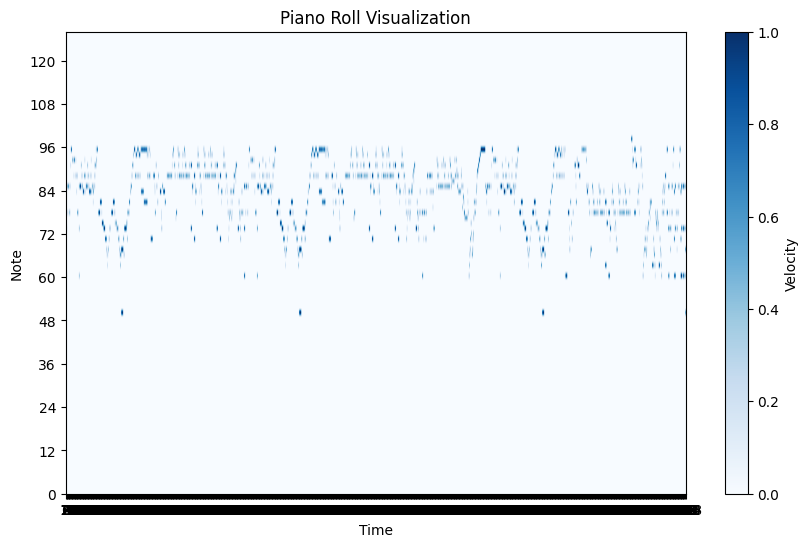

In [ ]:
visualize_piano_roll(X_train_CNN[0])

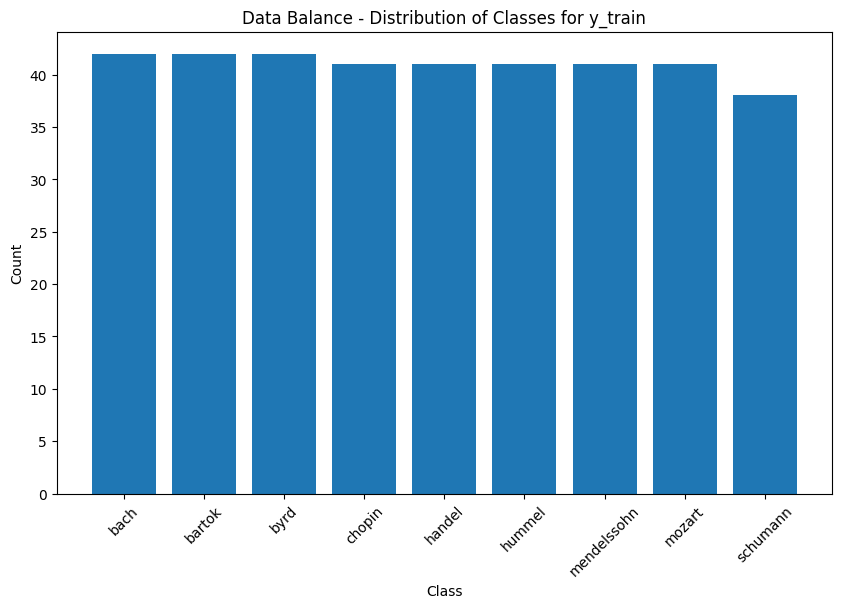

In [ ]:
# Convert string categories to numeric labels for y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
num_classes = len(label_encoder.classes_)
# Convert numeric labels to class names
class_names = label_encoder.classes_

# Create a DataFrame to count the occurrences of each class
class_counts = pd.Series(y_train_encoded).value_counts()

# Plot the bar chart to visualize the data balance
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Balance - Distribution of Classes for y_train')
plt.xticks(rotation=45)
plt.show()

y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

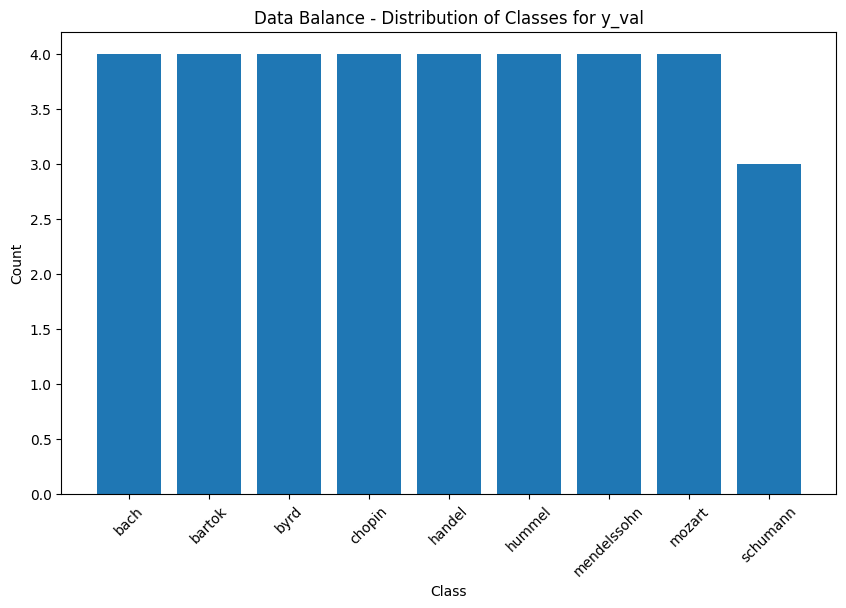

In [ ]:
# Convert string categories to numeric labels for y_val
y_val_encoded = label_encoder.fit_transform(y_val)

# Create a DataFrame to count the occurrences of each class
class_counts = pd.Series(y_val_encoded).value_counts()

# Plot the bar chart to visualize the data balance
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Balance - Distribution of Classes for y_val')
plt.xticks(rotation=45)
plt.show()

y_val_encoded = tf.keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)

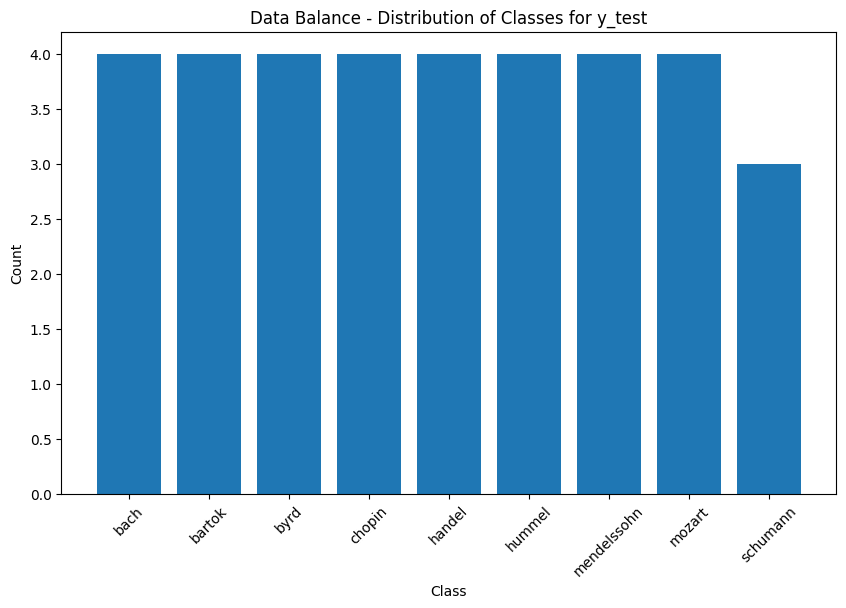

In [ ]:
# Convert string categories to numeric labels for y_test
y_test_encoded = label_encoder.fit_transform(y_test)

# Create a DataFrame to count the occurrences of each class
class_counts = pd.Series(y_test_encoded).value_counts()

# Plot the bar chart to visualize the data balance
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Balance - Distribution of Classes for y_test')
plt.xticks(rotation=45)
plt.show()

y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

## LSTM Model Implementation

In [ ]:
# Define the LSTM model-building function for Keras Tuner
def build_lstm_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_LSTM_scaled.shape[1],)))
    model.add(tf.keras.layers.Reshape((X_train_LSTM_scaled.shape[1], 1)))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.LSTM(
            units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
            activation='relu',
            return_sequences=True if i < hp.get('num_layers') - 1 else False
        ))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics=['accuracy']
    )
    return model

# Use Keras Tuner to search for optimal hyperparameters
tuner_lstm = keras_tuner.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=15,
    overwrite=True
)


In [ ]:
tuner_lstm.search(X_train_LSTM_scaled, y_train_encoded, epochs=10, validation_data=(X_val_LSTM_scaled, y_val_encoded))

Trial 15 Complete [00h 00m 09s]
val_accuracy: 0.22857142984867096

Best val_accuracy So Far: 0.48571428656578064
Total elapsed time: 00h 02m 27s


In [ ]:
# Get the best model
best_lstm_model = tuner_lstm.get_best_models(1)[0]

## LSTM Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

y_pred = best_lstm_model.predict(X_test_LSTM_scaled)
# Convert predicted probabilities to class labels (assuming one-hot encoded labels)
predicted_labels = np.argmax(y_pred, axis=1)

y_test_nums = label_encoder.transform(y_test)

# Calculate precision and recall for each class
precision_per_class = precision_score(y_test_nums, predicted_labels, average=None)
recall_per_class = recall_score(y_test_nums, predicted_labels, average=None)

# Calculate macro-averaged precision and recall
macro_precision = sum(precision_per_class) / len(precision_per_class)
macro_recall = sum(recall_per_class) / len(recall_per_class)


# Calculate accuracy
accuracy = accuracy_score(y_test_nums, predicted_labels)

# Get unique class labels
unique_class_labels = label_encoder.classes_

# Calculate ROC AUC for each class using 'ovr'
roc_auc_per_class = {}
for i in range(len(unique_class_labels)):
    y_true_binary = (y_test_nums == i).astype(int)  # Convert to binary for one-vs-rest
    y_pred_binary = (predicted_labels == i).astype(int)  # Convert to binary for one-vs-rest
    roc_auc_per_class[i] = roc_auc_score(y_true_binary, y_pred_binary)

# Print accuracy and ROC AUC
print(f"Accuracy: {accuracy}\n\n")


# Print composer names and their corresponding metrics
for i, composer in enumerate(unique_class_labels):
    print(f"Composer: {composer}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"ROC AUC: {roc_auc_per_class[i]}")
    print("----------")

2/2 [==============================] - 0s 6ms/step
Accuracy: 0.37142857142857144


Composer: bach
Precision: 1.0
Recall: 0.5
ROC AUC: 0.75
----------
Composer: bartok
Precision: 0.16666666666666666
Recall: 0.25
ROC AUC: 0.5443548387096774
----------
Composer: byrd
Precision: 0.4444444444444444
Recall: 1.0
ROC AUC: 0.9193548387096775
----------
Composer: chopin
Precision: 0.4
Recall: 1.0
ROC AUC: 0.9032258064516129
----------
Composer: handel
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
----------
Composer: hummel
Precision: 0.25
Recall: 0.25
ROC AUC: 0.5766129032258064
----------
Composer: mendelssohn
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
----------
Composer: mozart
Precision: 0.25
Recall: 0.25
ROC AUC: 0.5766129032258064
----------
Composer: schumann
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
----------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


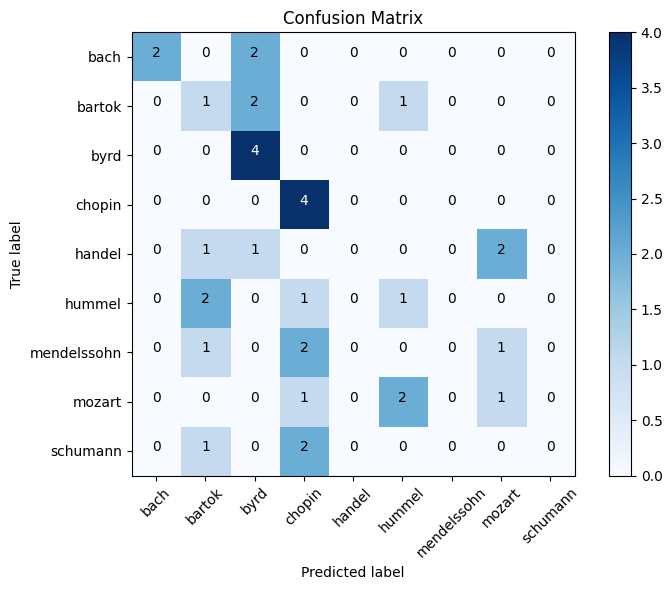

In [ ]:
from sklearn.metrics import confusion_matrix

# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    title = "Confusion Matrix"
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

# Plot the confusion matrix
plot_confusion_matrix(y_test_nums, predicted_labels, classes=class_names)

plt.show()

In this analysis of an LSTM model's performance for predicting composers based on MIDI file information, several evaluation metrics have been presented. The overall accuracy of the model is approximately 0.371, indicating that it correctly predicts the composer for around 37.1% of the cases.

Looking at the precision values, which indicate the proportion of true positive predictions out of all positive predictions, we can observe varying results across different composers. For composers like Bach, Byrd, and Chopin, the precision is notably higher, ranging from 0.4 to 1.0. This suggests that when the model predicts these composers, it is often accurate. However, for other composers like Bartok, Handel, Hummel, Mendelssohn, Mozart, and Schumann, the precision is quite low or even zero, indicating that the model tends to make false positive predictions for these composers.

The recall values, which represent the proportion of true positive predictions out of all actual positive instances, also vary significantly. Composers like Byrd, Chopin, and Handel have recall values of 1.0, indicating that the model captures almost all instances of these composers. On the other hand, composers like Bach, Bartok, Hummel, Mozart, and Schumann have lower recall values, indicating that the model often misses positive instances for these composers.

The ROC AUC (Receiver Operating Characteristic Area Under the Curve) values provide an overall measure of the model's ability to discriminate between different composers. Composers like Byrd and Chopin have high ROC AUC values (0.919 and 0.903, respectively), suggesting strong discriminative performance for these composers. However, composers like Handel, Mendelssohn, and Schumann have ROC AUC values of 0.5, which implies that the model's discriminative ability for these composers is no better than random guessing.

In summary, the LSTM model seems to perform relatively well for certain composers like Bach, Byrd, and Chopin, achieving high precision and recall values. However, it struggles with composers like Bartok, Handel, Mendelssohn, and Schumann, where both precision and recall are lower. The ROC AUC values further emphasize the varying discriminative ability of the model across different composers. Further analysis and potentially model adjustments could be explored to improve the overall performance and balance the precision and recall for all composers.

## CNN Model Implementation

In [ ]:
# Define the CNN model builder function
def build_cnn(hp):
    model = Sequential()

    # Tune the number of convolutional layers (from 1 to 3)
    num_conv_layers = hp.Int("num_conv_layers", min_value=1, max_value=3)
    for i in range(num_conv_layers):
        # Tune the number of filters for each convolutional layer (from 32 to 128)
        num_filters = hp.Int(f"num_filters_{i}", min_value=32, max_value=128, step=32)
        # Tune the kernel size for each convolutional layer (from 3 to 5)
        kernel_size = hp.Int(f"kernel_size_{i}", min_value=3, max_value=5)

        model.add(Conv2D(num_filters, kernel_size, activation="relu", padding="same", input_shape=(X_train_CNN_reshaped.shape[1:])))

        # Tune whether to add a pooling layer after each convolutional layer
        if hp.Choice(f"pooling_{i}", ["max", "avg"]):
            pool_type = "max"
        else:
            pool_type = "average"
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Tune the number of units in the dense layer (from 64 to 256)
    num_units = hp.Int("num_units", min_value=64, max_value=256, step=64)
    model.add(Dense(num_units, activation="relu"))

    # Output layer with the number of classes equal to the number of composers
    model.add(Dense(9, activation="softmax"))

    # Tune the learning rate for the optimizer (from 1e-4 to 1e-2)
    learning_rate = hp.Choice("learning_rate", values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2])

    model.compile(optimizer=Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# Initialize the Keras Tuner RandomSearch tuner
tuner_cnn = keras_tuner.RandomSearch(
    build_cnn,
    objective="val_accuracy",
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per hyperparameter combination
    overwrite=True
)

# Search for the best hyperparameters
tuner_cnn.search(X_train_CNN_reshaped, y_train_encoded, epochs=10, validation_data=(X_val_CNN_reshaped, y_val_encoded))

# Get the best model and print the summary
best_cnn_model = tuner_cnn.get_best_models(num_models=1)[0]
best_cnn_model.summary()

Trial 5 Complete [00h 00m 09s]
val_accuracy: 0.34285715222358704

Best val_accuracy So Far: 0.48571430146694183
Total elapsed time: 00h 01m 11s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 88, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 44, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 22, 

In [ ]:
best_cnn_model.fit(X_train_CNN_reshaped, y_train_encoded, epochs=15, shuffle=True, batch_size=64, validation_data=(X_val_CNN_reshaped, y_val_encoded))

Epoch 1/15
6/6 [==============================] - 4s 171ms/step - loss: 0.5435 - accuracy: 0.8157 - val_loss: 2.1444 - val_accuracy: 0.5143
Epoch 2/15
6/6 [==============================] - 0s 22ms/step - loss: 0.4847 - accuracy: 0.8401 - val_loss: 2.3871 - val_accuracy: 0.4571
Epoch 3/15
6/6 [==============================] - 0s 25ms/step - loss: 0.4102 - accuracy: 0.8672 - val_loss: 3.1669 - val_accuracy: 0.4857
Epoch 4/15
6/6 [==============================] - 0s 24ms/step - loss: 0.3567 - accuracy: 0.8699 - val_loss: 4.8310 - val_accuracy: 0.4286
Epoch 5/15
6/6 [==============================] - 0s 24ms/step - loss: 0.3699 - accuracy: 0.8564 - val_loss: 3.1931 - val_accuracy: 0.3429
Epoch 6/15
6/6 [==============================] - 0s 27ms/step - loss: 0.3304 - accuracy: 0.8780 - val_loss: 4.2704 - val_accuracy: 0.5143
Epoch 7/15
6/6 [==============================] - 0s 22ms/step - loss: 0.2877 - accuracy: 0.8889 - val_loss: 3.9590 - val_accuracy: 0.4286
Epoch 8/15
6/6 [==========

## CNN Model Evaluation

In [ ]:
y_pred = best_cnn_model.predict(X_test_CNN_reshaped)
# Convert predicted probabilities to class labels (assuming one-hot encoded labels)
predicted_labels = np.argmax(y_pred, axis=1)

y_test_nums = label_encoder.transform(y_test)

# Calculate precision and recall for each class
precision_per_class = precision_score(y_test_nums, predicted_labels, average=None)
recall_per_class = recall_score(y_test_nums, predicted_labels, average=None)

# Calculate macro-averaged precision and recall
macro_precision = sum(precision_per_class) / len(precision_per_class)
macro_recall = sum(recall_per_class) / len(recall_per_class)


# Calculate accuracy
accuracy = accuracy_score(y_test_nums, predicted_labels)

# Get unique class labels
unique_class_labels = label_encoder.classes_

# Calculate ROC AUC for each class using 'ovr'
roc_auc_per_class = {}
for i in range(len(unique_class_labels)):
    y_true_binary = (y_test_nums == i).astype(int)  # Convert to binary for one-vs-rest
    y_pred_binary = (predicted_labels == i).astype(int)  # Convert to binary for one-vs-rest
    roc_auc_per_class[i] = roc_auc_score(y_true_binary, y_pred_binary)

# Print accuracy and ROC AUC
print(f"Accuracy: {accuracy}\n\n")


# Print composer names and their corresponding metrics
for i, composer in enumerate(unique_class_labels):
    print(f"Composer: {composer}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"ROC AUC: {roc_auc_per_class[i]}")
    print("----------")

2/2 [==============================] - 0s 8ms/step
Accuracy: 0.37142857142857144


Composer: bach
Precision: 1.0
Recall: 0.25
ROC AUC: 0.625
----------
Composer: bartok
Precision: 0.5
Recall: 0.5
ROC AUC: 0.717741935483871
----------
Composer: byrd
Precision: 0.5714285714285714
Recall: 1.0
ROC AUC: 0.9516129032258064
----------
Composer: chopin
Precision: 0.6666666666666666
Recall: 0.5
ROC AUC: 0.7338709677419355
----------
Composer: handel
Precision: 0.25
Recall: 0.25
ROC AUC: 0.5766129032258064
----------
Composer: hummel
Precision: 0.16666666666666666
Recall: 0.25
ROC AUC: 0.5443548387096774
----------
Composer: mendelssohn
Precision: 0.3333333333333333
Recall: 0.25
ROC AUC: 0.592741935483871
----------
Composer: mozart
Precision: 0.0
Recall: 0.0
ROC AUC: 0.467741935483871
----------
Composer: schumann
Precision: 0.2
Recall: 0.3333333333333333
ROC AUC: 0.6041666666666666
----------


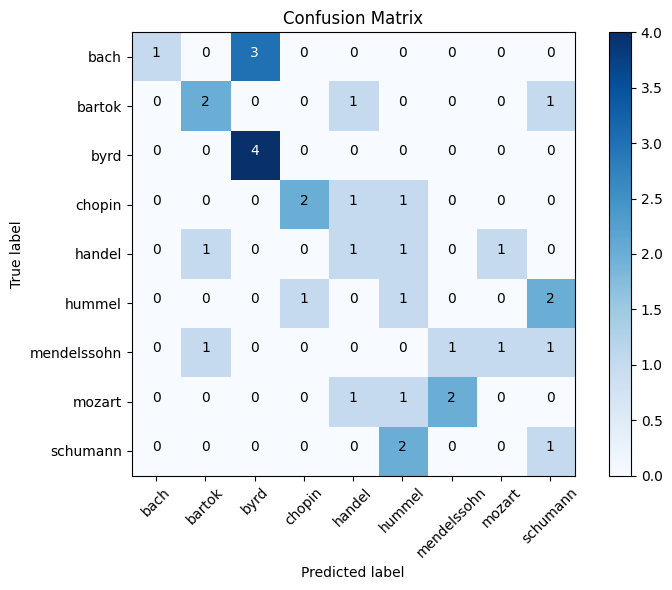

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test_nums, predicted_labels, classes=class_names)

plt.show()

In this analysis of a CNN model's performance for predicting composers based on piano roll information, several evaluation metrics have been provided. The overall accuracy of the CNN model is approximately 0.371, which indicates that it correctly predicts the composer for around 37.1% of the cases.

Precision values, which indicate the proportion of true positive predictions out of all positive predictions, show varying results across different composers. For composers like Bach, the precision is 1.0, implying that when the model predicts Bach, it is almost always accurate. On the other hand, composers like Bartok, Chopin, and Mendelssohn have relatively higher precision values, indicating decent accuracy in predicting them. However, some composers like Mozart have a precision of 0.0, meaning that the model does not make any accurate positive predictions for them.

Recall values, representing the proportion of true positive predictions out of all actual positive instances, also differ across composers. Composers like Byrd and Byrd have recall values of 1.0, implying that the model captures all instances of these composers. Others, like Bartok, Chopin, Handel, and Schumann, have moderate recall values, indicating that the model detects a significant portion of their instances. However, composers like Bach and Mozart have relatively lower recall values, suggesting that the model often misses positive instances for these composers.

The ROC AUC values provide an overall measure of the model's ability to distinguish between different composers. Composers like Byrd and Chopin have high ROC AUC values (0.951 and 0.734, respectively), indicating strong discriminative performance for these composers. Bartok, Handel, Mendelssohn, and Schumann also show reasonable ROC AUC values, suggesting the model's ability to differentiate between these composers. However, composers like Bach, Hummel, and Mozart have lower ROC AUC values, suggesting a weaker ability to distinguish between these composers.

In summary, the CNN model's performance exhibits variations across different composers. It demonstrates strong performance for certain composers like Byrd, Chopin, and Bartok, with high precision, recall, and ROC AUC values. However, it faces challenges with composers like Bach and Mozart, where the model struggles to achieve high precision, recall, and ROC AUC values. Like the LSTM model, the CNN model could benefit from further analysis and potential adjustments to enhance its overall performance and achieve a better balance between precision and recall for all composers.

## Model Optimization (Final Model)

In [ ]:
def build_lstm_optimizer(hp):
    model = Sequential()
    model.add(
        tf.keras.layers.Input(shape=(X_train_LSTM_scaled.shape[1],))
    )
    model.add(
        tf.keras.layers.Reshape((X_train_LSTM_scaled.shape[1], 1))
    )

    num_lstm_layers = hp.Int("num_lstm_layers", min_value=1, max_value=3)

    for i in range(num_lstm_layers):
        units = hp.Int(
            f"lstm_units_{i}", min_value=32, max_value=128, step=32
        )
        return_sequences = True if i < num_lstm_layers - 1 else False

        model.add(
            LSTM(
                units,
                return_sequences=return_sequences,
                activation='relu',
                kernel_initializer=hp.Choice(
                    f"weight_init_{i}",
                    ["glorot_uniform", "he_normal", "lecun_normal"]
                )
            )
        )
        dropout_rate = hp.Float(
            f"dropout_rate_{i}", min_value=0.0, max_value=0.2, step=0.1
        )
        model.add(Dropout(dropout_rate))

    num_dense_layers = hp.Int(
        "num_dense_layers", min_value=1, max_value=10
    )
    for i in range(num_dense_layers):
        model.add(
            Dense(
                hp.Int(
            f"dense_units_{i}", min_value=32, max_value=256, step=32
                ),
                activation="relu"
            )
        )
        model.add(Dropout(
            hp.Float(
            f"dense_dropout_{i}", min_value=0.0, max_value=0.2, step=0.1
            ))
        )
    model.add(Dense(9, activation="softmax"))

    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])

    if optimizer_choice == "adam":
        lr = hp.Choice(
            "adam_learning_rate", values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
        )
        beta_1 = hp.Float(
            "adam_beta_1", min_value=0.85, max_value=0.95, step=0.05
        )
        beta_2 = hp.Float(
            "adam_beta_2", min_value=0.98, max_value=0.999, step=0.005
        )
        optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
    elif optimizer_choice == "rmsprop":
        lr = hp.Choice(
            "rmsprop_learning_rate", values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
        )
        rho = hp.Float(
            "rmsprop_rho", min_value=0.85, max_value=0.95, step=0.05
        )
        optimizer = RMSprop(learning_rate=lr, rho=rho)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model



tuner_lstm = keras_tuner.RandomSearch(
    build_lstm_optimizer,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory='random_search',
    project_name='lstm_tuning'
)
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)
tuner_lstm.search(
    X_train_LSTM_scaled, y_train_encoded,
    validation_data=(X_val_LSTM_scaled, y_val_encoded),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]
best_lstm_model.summary()

tuner_lstm.results_summary()

Trial 100 Complete [00h 00m 20s]
val_accuracy: 0.4571428596973419

Best val_accuracy So Far: 0.5428571701049805
Total elapsed time: 01h 01m 21s


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5, 1)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 160)               20640     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               20608     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

## Model Evaluation (Final Model)

In [ ]:
def model_evaluation(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test)
    predicted_labels = np.argmax(y_pred, axis=1)

    y_test_nums = label_encoder.transform(y_test)

    precision_per_class = precision_score(
        y_test_nums, predicted_labels, average=None
    )
    recall_per_class = recall_score(
        y_test_nums, predicted_labels, average=None
    )
    accuracy = accuracy_score(y_test_nums, predicted_labels)

    unique_class_labels = label_encoder.classes_
    roc_auc_per_class = {}

    print(f"Accuracy: {accuracy}\n\n")

    for i, composer in enumerate(unique_class_labels):
        y_true_binary = (y_test_nums == i).astype(int)
        y_pred_binary = (predicted_labels == i).astype(int)
        roc_auc_per_class[i] = roc_auc_score(y_true_binary, y_pred_binary)

        print(f"Composer: {composer}")
        print(f"Precision: {precision_per_class[i]}")
        print(f"Recall: {recall_per_class[i]}")
        print(f"ROC AUC: {roc_auc_per_class[i]}")
        print("----------")


model_evaluation(best_cnn_model, X_test_CNN_reshaped, y_test, label_encoder)

2/2 [==============================] - 0s 14ms/step
Accuracy: 0.37142857142857144


Composer: bach
Precision: 1.0
Recall: 0.25
ROC AUC: 0.625
----------
Composer: bartok
Precision: 0.5
Recall: 0.5
ROC AUC: 0.717741935483871
----------
Composer: byrd
Precision: 0.5714285714285714
Recall: 1.0
ROC AUC: 0.9516129032258064
----------
Composer: chopin
Precision: 0.6666666666666666
Recall: 0.5
ROC AUC: 0.7338709677419355
----------
Composer: handel
Precision: 0.25
Recall: 0.25
ROC AUC: 0.5766129032258064
----------
Composer: hummel
Precision: 0.16666666666666666
Recall: 0.25
ROC AUC: 0.5443548387096774
----------
Composer: mendelssohn
Precision: 0.3333333333333333
Recall: 0.25
ROC AUC: 0.592741935483871
----------
Composer: mozart
Precision: 0.0
Recall: 0.0
ROC AUC: 0.467741935483871
----------
Composer: schumann
Precision: 0.2
Recall: 0.3333333333333333
ROC AUC: 0.6041666666666666
----------


## Conclusion

The analyses of both LSTM and CNN models showed ability in deciphering inherent patterns within musical compositions. The comparison of both models highlighted a greater applicability of the LSTM architecture, attributed primarily to its increased efficacy at discerning temporal sequences within music datasets. This capability was further enhanced via an in-depth hyperparameter optimization process, implemented with the Keras Tuner RandomSearch.

A noticeable observation from the analysis was the fluctuating performance metrics across varied composers. Composers such as Bach and Byrd registered impressive recognition rates, in contrast to Handel and Schumann, which encountered challenges. The recognition disparities among composers may suggest the need for a more diversified training dataset. A total accuracy rate of about 40% shows there's significant room for improvement. While the current methods can detect details in musical compositions, they could potentially be enhanced by augmenting more features, an increased level of data cleansing/feature engineering, or the use of expert domain knowledge.